In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from phantoms.utils.CKA.cka_processing import shared_subspace_analysis
from phantoms.utils.CKA.cka_data import load_embeddings

In [4]:


# Assume the following helper functions are already defined and imported:
# - load_embeddings(experiment_dir, layer_names)
# - shared_subspace_analysis(X, Y, center=True)
#   (This function returns sorted eigenvalues, projection norms, and cosine similarities)

def compute_projection_norm_metric(X, Y, top_k=5, center=True):
    """
    Computes an aggregate projection norm metric between representations X and Y for a given layer.
    
    This function performs shared subspace analysis and returns the average of the projection norms 
    (||S_Y u_i||) over the top_k eigenvectors.
    
    Args:
        X (np.ndarray): Activation matrix from model A of shape [num_examples, dim].
        Y (np.ndarray): Activation matrix from model B of shape [num_examples, dim].
        top_k (int): Number of top eigenvectors to consider.
        center (bool): Whether to center the data.
        
    Returns:
        float: Average projection norm over the top_k eigenvectors.
    """
    eigvals, proj_norms, cosines = shared_subspace_analysis(X, Y, center=center)
    top_norms = proj_norms[:min(top_k, len(proj_norms))]
    return np.mean(top_norms)

def aggregate_projection_norm_metric(exp_dirs, layer_names, top_k=5, center=True):
    """
    For a list of experiment directories, compute the projection norm metric for each layer
    by comparing each unique pair of experiments using shared subspace analysis,
    and then aggregate the results by computing the mean and std for each layer.
    
    Args:
        exp_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names.
        top_k (int): Number of top eigenvectors to consider.
        center (bool): Whether to center the data.
        
    Returns:
        agg_dict (dict): Dictionary mapping each layer name to a tuple (mean, std, all_scores),
                         where all_scores is a list of projection norm metrics computed across pairs.
    """
    agg_dict = {layer: [] for layer in layer_names}
    # Pre-load embeddings for all experiments.
    models_embeddings = {}
    for exp_dir in exp_dirs:
        models_embeddings[exp_dir] = load_embeddings(exp_dir, layer_names)
    
    # Iterate over all unique pairs.
    for exp1, exp2 in itertools.combinations(exp_dirs, 2):
        emb1 = models_embeddings[exp1]
        emb2 = models_embeddings[exp2]
        for layer in layer_names:
            if layer in emb1 and layer in emb2:
                X = emb1[layer]  # shape: [num_examples, dim]
                Y = emb2[layer]
                metric = compute_projection_norm_metric(X, Y, top_k=top_k, center=center)
                agg_dict[layer].append(metric)
    
    # Compute mean and std for each layer.
    for layer in agg_dict:
        scores = np.array(agg_dict[layer])
        if scores.size > 0:
            mean_val = np.mean(scores)
            std_val = np.std(scores)
        else:
            mean_val, std_val = np.nan, np.nan
        agg_dict[layer] = (mean_val, std_val, agg_dict[layer])
    return agg_dict

def plot_aggregated_projection_norm_by_group(experiment_groups, layer_names, top_k=5, center=True):
    """
    Given a dictionary mapping group labels (e.g. ms levels or model types) to lists of experiment directories,
    compute the aggregated projection norm metric for each group and plot one curve (with error bars)
    per group over layers.
    
    Args:
        experiment_groups (dict): Mapping from group label (str) to list of experiment directory paths.
        layer_names (list): List of layer names.
        top_k (int): Number of top eigenvectors to consider.
        center (bool): Whether to center the data.
    """
    group_results = {}
    for group_label, exp_dirs in experiment_groups.items():
        agg_dict = aggregate_projection_norm_metric(exp_dirs, layer_names, top_k=top_k, center=center)
        means = []
        stds = []
        for layer in layer_names:
            mean_val, std_val, _ = agg_dict.get(layer, (np.nan, np.nan, []))
            means.append(mean_val)
            stds.append(std_val)
        group_results[group_label] = (np.arange(len(layer_names)), np.array(means), np.array(stds))
    
    plt.figure(figsize=(12, 8))
    for group_label, (x, means, stds) in group_results.items():
        plt.errorbar(x, means, yerr=stds, fmt='-o', capsize=5, label=group_label)
    plt.xticks(x, layer_names, rotation=45, ha='right')
    plt.xlabel("Layer")
    plt.ylabel("Average Projection Norm (Top {})".format(top_k))
    plt.title("Aggregated Projection Norm vs. Layer (by Group)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---

# For grouping by ms level, define a dictionary such as:
# experiment_levels = {
#     "ms2": experiment_level_2,  
#     "ms3": experiment_level_3,
#     "ms4": experiment_level_4,
#     "ms5": experiment_level_5
# }
# plot_aggregated_projection_norm_by_group(experiment_levels, layer_names, top_k=5, center=True)

# Alternatively, for grouping by model type (e.g., dreams, dreams_bonus, raw_spectra, raw_spectra_bonus):
# experiment_types = {
#     "dreams": experiment_dreams,
#     "dreams_bonus": experiment_dreams_bonus,
#     "raw_spectra": experiment_raw_spectra,
#     "raw_spectra_bonus": experiment_raw_spectra_bonus
# }
# plot_aggregated_projection_norm_by_group(experiment_types, layer_names, top_k=5, center=True)

In [5]:
# Specify the layers you want to compare
layer_names = ['gnn_1_head_1_mean',
'gnn_1_head_2_mean',
'gnn_1_head_3_mean',
'gnn_1_head_4_mean',
'gnn_2_head_1_mean',
'gnn_2_head_2_mean',
'gnn_2_head_3_mean',
'gnn_2_head_4_mean',
'gnn_3_head_1_mean',
'gnn_3_head_2_mean',
'gnn_3_head_3_mean',
'gnn_3_head_4_mean',
'head_head_fc1',
'head_skipblock_1_hidden1',
'head_skipblock_1_hidden2',
'head_skipblock_2_hidden1',
'head_skipblock_2_hidden2',
'head_skipblock_3_hidden1',
'head_skipblock_3_hidden2',
'head_skipblock_4_hidden1',
'head_skipblock_4_hidden2', 
'head_skipblock_5_hidden1',
'head_skipblock_5_hidden2',
'head_skipblock_6_hidden1',
'head_skipblock_6_hidden2',
'head_head_fc_final',
]

## Dreams

In [6]:
experiment_dreams = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31'
]

## Dreams Bonus

In [7]:
experiment_dreams_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08'
]

## Raw Spectra 

In [8]:
experiment_raw_spectra = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28'
]

## Raw Spectra Bonus 

In [9]:
experiment_raw_spectra_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53'
]

## AGGREGATE

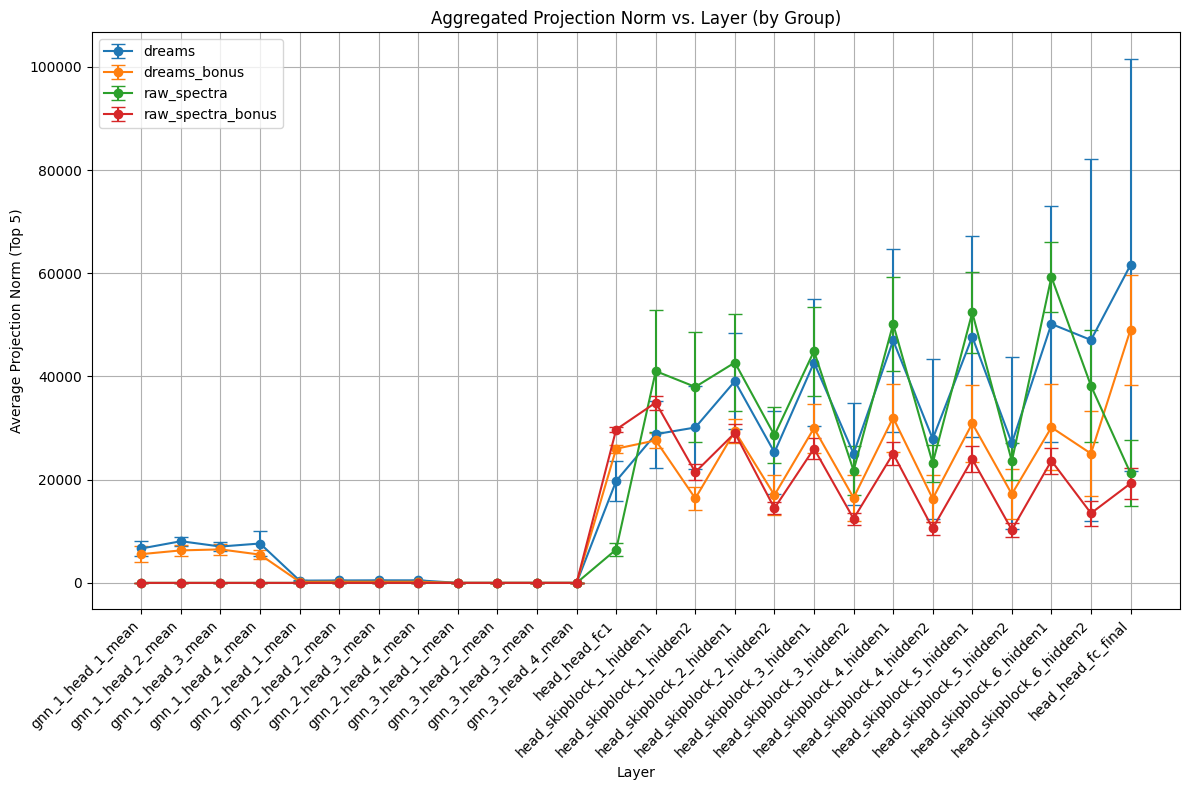

In [10]:
experiment_types = {
    "dreams": experiment_dreams,
    "dreams_bonus": experiment_dreams_bonus,
    "raw_spectra": experiment_raw_spectra,
    "raw_spectra_bonus": experiment_raw_spectra_bonus
}
plot_aggregated_projection_norm_by_group(experiment_types, layer_names, top_k=5, center=True)

# By level

## level 2

In [ ]:
experiment_level_2 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
]

## level 3

In [ ]:
experiment_level_3 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
]

## level 4

In [ ]:
experiment_level_4 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
]

## level 5

In [ ]:
experiment_level_5 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08',
]

# AGGREGATE

In [ ]:
experiment_levels = {
    "ms2": experiment_level_2,  
    "ms3": experiment_level_3,
    "ms4": experiment_level_4,
    "ms5": experiment_level_5
}